# Project Phase 1 
## SimBoost


#### Name: Yasamin Tabatabaee
#### Student No.: 95104866

Drug discovery is a time-consuming, laborious, costly and high-risk process. According to a report by the Eastern Research Group (ERG), it usually takes 10-15 years to develop a new drug. However, the success rate of developing a new molecular entity is only 2.01%. \
Finding a compound that selectively binds to a particular protein is a highly challenging and typically expensive procedure in the drug development process. \
In this project we are going to implement [SimBoost](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5395521/#CR42) which is machine-learning approch for predicting drug–target binding affinities using gradient boosting.




We will be using [Davis](http://staff.cs.utu.fi/~aatapa/data/DrugTarget/) dataset, which contains selectivity assays of the kinase protein family and the relevant inhibitors with their respective dissociation constant (Kd) values. It comprises interactions of 442 proteins and 68 drugs.

## 1. Setup (15 Points)

### 1.1 Imports libs

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### 1.2 Loading data

We need following files for this project:
- `target_gene_names.txt`: gene names of the targets
- `drug_PubChem_CIDs.txt`: PubChem CIDs of the drugs
- `drug-drug_similarities_2D.txt`: drug-drug structural fingerprint similarities computed the Structure Clustering sever at PubChem
- `target-target_similarities_WS_normalized.txt`: target-target sequence similarities computed with the normalized versions of the Smith-Waterman (SW) score.
- `drug-target_interaction_affinities_Kd__Davis_et_al.2011.txt`: drug-target interaction affinities.

The rows (and columns) of the drug-drug similarity matrices correspond to the rows of the interaction affinity matrix and the rows (and columns) of the target-target similarity matrices correspond to the columns of the interaction affinity matrix.

In [58]:
target_gene_names = pd.read_csv("target_gene_names.txt", header=None, index_col = 0)
drug_pubchemIDs = pd.read_csv("drug_PubChem_CIDs.txt", header=None, index_col = 0)

#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Load each file using pd.read_csv and use target_gene_names and drug_pubchemIDs
# to correspond row index and columns of all three files.
# sim_targets.shape == (442, 442)
# sim_drugs.shape == (68, 68)
# bindings.shape == (68, 442)
# Note that target_gene_names and drug_pubchemIDs dataframes are empty, we are
# going to fill them with features.
#################################################################################

sim_targets = pd.read_csv("target-target_similarities_WS_normalized.txt", names = target_gene_names.index.tolist(), sep = ' ')
sim_drugs = pd.read_csv("drug-drug_similarities_2D.txt", names = drug_pubchemIDs.index.tolist(), sep = ' ')
bindings = pd.read_csv("drug-target_interaction_affinities_Kd__Davis_et_al.2011.txt", names = target_gene_names.index.tolist(), sep = ' ')
bindings.index = drug_pubchemIDs.index.tolist()
sim_drugs.index = drug_pubchemIDs.index.tolist()
sim_targets.index = target_gene_names.index.tolist()

#################################################################################
#                                   THE END                                     #
#################################################################################

sim_targets.shape, sim_drugs.shape, bindings.shape

Index(['AAK1', 'ABL1(E255K)-phosphorylated', 'ABL1(F317I)-nonphosphorylated',
       'ABL1(F317I)-phosphorylated', 'ABL1(F317L)-nonphosphorylated',
       'ABL1(F317L)-phosphorylated', 'ABL1(H396P)-nonphosphorylated',
       'ABL1(H396P)-phosphorylated', 'ABL1(M351T)-phosphorylated',
       'ABL1(Q252H)-nonphosphorylated',
       ...
       'WEE1', 'WEE2', 'YANK1', 'YANK2', 'YANK3', 'YES', 'YSK1', 'YSK4', 'ZAK',
       'ZAP70'],
      dtype='object', length=442)


### 1.3 Preprocessing

In davis dataset, standard value is Kd in nM. we used the transformation below:

### $pK_{d}=-log_{10}\frac{K_d}{1e9}$ 


In [55]:
drug_pubchemIDs.sort_index(inplace=True)
target_gene_names.sort_index(inplace=True)
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# sort sim_targets, sim_drugs, bindings based on their index like above 
# divide all values of sim_targets by 100
# transform binding values as mentioned above
#################################################################################

sim_targets.sort_index(inplace=True)
sim_targets = sim_targets / 100
sim_drugs.sort_index(inplace=True)
bindings.sort_index(inplace=True)
transformed_bindings = - np.log10(bindings / np.exp(9))

#################################################################################
#                                   THE END                                     #
#################################################################################
# bindings.head()
transformed_bindings.head()

,AAK1,ABL1(E255K)-phosphorylated,ABL1(F317I)-nonphosphorylated,ABL1(F317I)-phosphorylated,ABL1(F317L)-nonphosphorylated,ABL1(F317L)-phosphorylated,ABL1(H396P)-nonphosphorylated,ABL1(H396P)-phosphorylated,ABL1(M351T)-phosphorylated,ABL1(Q252H)-nonphosphorylated,...,WEE1,WEE2,YANK1,YANK2,YANK3,YES,YSK1,YSK4,ZAK,ZAP70
5291,-0.091350,1.678201,2.989572,1.145222,3.510710,1.867258,3.137798,2.095737,2.265198,3.653378,...,-0.091350,-0.091350,-0.091350,-0.091350,-0.091350,-0.091350,-0.091350,-0.091350,0.493677,-0.091350
44259,3.829469,2.566228,1.168288,1.794707,1.678201,2.245893,2.653378,2.352348,2.192647,2.586431,...,0.704530,-0.091350,2.794707,1.917424,1.417289,2.192647,1.867258,3.974152,-0.091350,2.265198
123631,-0.091350,1.306590,-0.091350,0.236552,0.477287,1.016556,1.076141,1.245893,1.192647,0.867258,...,-0.091350,-0.091350,-0.091350,-0.091350,-0.091350,-0.091350,-0.091350,1.528439,-0.091350,-0.091350
126565,3.417289,0.984371,-0.091350,0.218454,0.027837,0.566228,0.908650,0.969131,1.016556,0.510710,...,0.829469,0.011023,0.586431,0.137798,0.005560,1.704530,1.921879,4.192647,0.082576,2.704530
151194,-0.091350,-0.091350,-0.091350,-0.091350,-0.091350,-0.091350,-0.091350,-0.091350,-0.091350,-0.091350,...,-0.091350,-0.091350,-0.091350,-0.091350,-0.091350,-0.091350,-0.091350,0.629897,0.265198,-0.091350


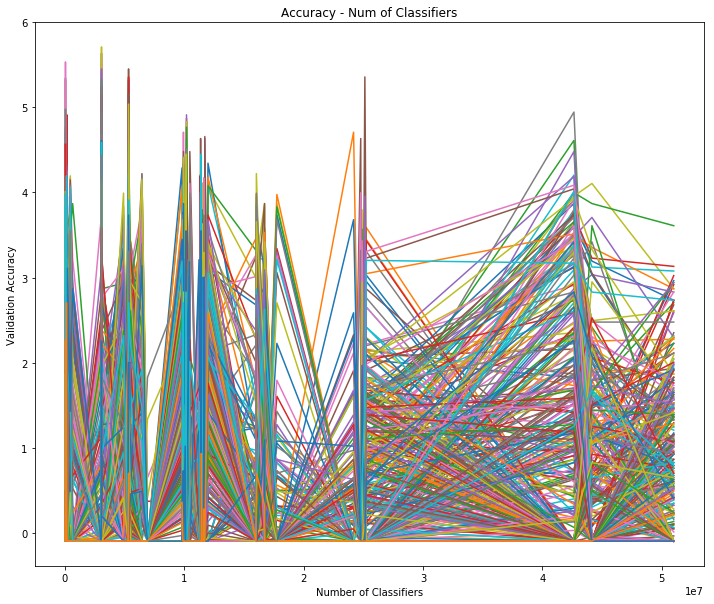

In [56]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Plot histogram of all values in transformed_bindings
# Hint: use .stack and .plot.hist  
#################################################################################

plt.figure(figsize=(12,10))
plt.plot(transformed_bindings)
plt.xlabel("Number of Classifiers")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy - Num of Classifiers")
plt.show() 
 
#################################################################################
#                                   THE END                                     #
#################################################################################

As you can see in histogram. The peak at pKd value 5 (10000 nM), These values correspond to the negative pairs that either have very weak binding affinities (Kd > 10000nM) or are not observed in the primary screen.

### 1.4 Drug-Target-Binding

In [92]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# use drug_target_binding and build drug_target_binding dataframe 
# in each row of dataframe you must have one drug-target pair and their 
# transformed binding value, in the end you must have a dataframe with 
# 30056 row and 3 columns ['Drug', 'Target', 'Binding_Val']
#################################################################################


index = pd.MultiIndex.from_product((bindings.index, bindings.columns), names=('Drug', 'Target'))
drug_target_binding = pd.DataFrame(columns=['Drug', 'Target', 'Binding_Val'])
for i in range(target_gene_names.shape[0]):
    for j in range(drug_pubchemIDs.shape[0]):
        drug_target_binding.loc[i * drug_pubchemIDs.shape[0] + j] = [drug_pubchemIDs.index[j], target_gene_names.index[i], transformed_bindings.iloc[j][i]]


#################################################################################
#                                   THE END                                     #
#################################################################################
print(bindings.head())  
print(bindings.index)
print(drug_target_binding.shape)
drug_target_binding.tail()

             AAK1  ABL1(E255K)-phosphorylated  ABL1(F317I)-nonphosphorylated  \
11314340     43.0                     10000.0                        10000.0   
24889392  10000.0                     10000.0                        10000.0   
11409972  10000.0                        75.0                            1.9   
11338033  10000.0                     10000.0                        10000.0   
10184653  10000.0                       420.0                         2900.0   

          ABL1(F317I)-phosphorylated  ABL1(F317L)-nonphosphorylated  \
11314340                     10000.0                       10000.00   
24889392                     10000.0                       10000.00   
11409972                        13.0                           0.77   
11338033                     10000.0                       10000.00   
10184653                       750.0                         580.00   

          ABL1(F317L)-phosphorylated  ABL1(H396P)-nonphosphorylated  \
11314340             

,Drug,Target,Binding_Val
30051,5494449,ZAP70,-0.091350
30052,3038525,ZAP70,-0.091350
30053,3081361,ZAP70,-0.091350
30054,9809715,ZAP70,-0.091350
30055,151194,ZAP70,0.493677


### 1.5 Train, Validation and Test Datasets

In [104]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# split drug_target_binding dataframe to 3 sets (train_data, val_data, test_data)
# split ratio is up to you
# at the end you must have 3 sets that each of them has 3 columns
#################################################################################

idx = np.random.permutation(drug_target_binding.index)
train_data = drug_target_binding.iloc[idx[:int(drug_target_binding.shape[0] * 0.7)], :]
val_data = drug_target_binding.iloc[idx[int(drug_target_binding.shape[0] * 0.7):int(drug_target_binding.shape[0] * 0.8)], :]
test_data = drug_target_binding.iloc[idx[int(drug_target_binding.shape[0] * 0.8):], :]

#################################################################################
#                                   THE END                                     #
#################################################################################
train_data.shape, val_data.shape, test_data.shape

((21039, 3), (3005, 3), (6012, 3))

## 2.Feature Engineering (35 Points)

In this part we are going to extract some feature for each target/drug. after that we will replace these features with their names/pubchemIDs. 

### 2.1 Average Similarities and Binding values

In [108]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# for each target compute their average similarities in sim_targets matrix
# and average binding value (in train_data).
# add these two feature as 'avg-sim', 'avg-binding' to target_gene_names DataFrame
#################################################################################

target_gene_names['avg-sim'] = sim_targets.mean()
target_gene_names['avg-binding'] = train_data.groupby('Target').mean()

#################################################################################
#                                   THE END                                     #
#################################################################################
target_gene_names.head()

,avg-sim,avg-binding
0,,
AAK1,47.917319,0.634102
ABL1(E255K)-phosphorylated,53.579599,0.926872
ABL1(F317I)-nonphosphorylated,53.579599,0.625220
ABL1(F317I)-phosphorylated,53.579599,0.597001
ABL1(F317L)-nonphosphorylated,53.579599,0.849007


In [28]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# for each drug compute their average similarities in sim_drugs matrix
# and average binding value (in train_data).
# add these two feature as 'avg-sim', 'avg-binding' to drug_pubchemIDs DataFrame
#################################################################################

drug_pubchemIDs['avg-sim'] = sim_targets.mean()
drug_pubchemIDs['avg-binding'] = train_data.groupby('Target').mean()

#################################################################################
#                                   THE END                                     #
#################################################################################
drug_pubchemIDs.head()

""
0
5291
44259
123631
126565
151194


### 2.2 Drug/Target Similarity Networks

#### 2.2.1 Build Networks

You must build two networks one for drugs and another one for targets. The nodes are drugs or targets, and an edge between two nodes exists if their similarity is above a threshold. The value of threshold is up to you. \
For building networks, we are going to use [igraph](https://igraph.org/) package. 

In [ ]:
import igraph

In [ ]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# define drug_sim_threshold, target_sim_threshold and use these values to
# build two network one for drugs and another one for targets using sim_drugs
# and sim_targets.
# Hint: you can use igraph.Graph.Adjacency, you can plot your graph using 
# igraph.plot
#################################################################################
drug_sim_threshold = None
target_sim_threshold = None


drug_graph = None
target_graph = None
#################################################################################
#                                   THE END                                     #
#################################################################################

Explain how you choose your threshold values? \
**Your Answer**

#### 2.2.2 Number of neighbors, PageRank

In [27]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# for each drug compute number of neighbors and it's PageRank score. 
# add these two feature as 'n_neighbors', 'page_rank' to drug_pubchemIDs DataFrame.
# do the above for each target too and add them to target_gene_names DataFrame.
# Hint: for pagerank score you can use graph.pagerank.
#################################################################################


#################################################################################
#                                   THE END                                     #
#################################################################################
target_gene_names.head()

""
0
AAK1
ABL1(E255K)-phosphorylated
ABL1(F317I)-nonphosphorylated
ABL1(F317I)-phosphorylated
ABL1(F317L)-nonphosphorylated


### 2.3 Non-negative Matrix Factorization

For extracting features from binding affinity matrix we are going to use [Non-negative Matrix Factorization](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization). 

In NMF, we are trying to approximately factor a matrix $B ∈ R_+^{d×t}$ (binding affinity matrix of d drugs and t targets) into two matrices $P ∈ R_+^{k×d}$ and $Q ∈ R_+^{k×t}$ which  $B = P^TQ$

In this problem, you can set $k$ (Latent dimension of $P$ and $Q$ matrices) to any number below 10.


The columns of the factor matrices P and Q are utilized as parts of the feature vectors for the drugs and targets respectively.

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# define latent_dim variable, after that use train_data to build bindings matrix
# because we remove some of the bindings values when we choose train_data in part 1.5  
# your matrix will have some na values fill them with 5 (Which is lowest binding score).
#################################################################################
latent_dim = None
train_binding_matrix = None
#################################################################################
#                                   THE END                                     #
#################################################################################
train_binding_matrix.head()

In [ ]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Use sklearn NMF and factor 'train_binding_matrix' to P and Q.
# add columns of P and Q as features to 'drug_pubchemIDs' and 'target_gene_names'
#################################################################################


#################################################################################
#                                   THE END                                     #
#################################################################################
target_gene_names.head()

### 2.4 Building Train, Validation and Test Dataset using extracted features

In [ ]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Replace drug pubchemID and Target gene name with extracted features.
# and build X (drug and target features) and Y (binding_values) for each dataset
# (Train, Validation, Test)
#################################################################################
X_train = None
Y_train = None

X_val = None
Y_val = None

X_test = None
Y_test = None

#################################################################################
#                                   THE END                                     #
#################################################################################
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

## 3.XGboost (25 Points)

To predict the continuous binding affinity for drug–target pairs, we will use [XGBoost](https://xgboost.readthedocs.io/en/latest/) library. 

You need to tune following hyperparameters:
- `learning_rate`: Boosting learning rate
- `n_estimators`: Number of gradient boosted trees.
- `max_depth `: Maximum tree depth for base learners.
- `colsample_bytree`: Subsample ratio of columns when constructing each tree.
- `subsample`: Subsample ratio of the training instance.




Note: `drug_sim_threshold`, `target_sim_threshold` and `latent_dim` in Feature Engineering part can be viewed as hyperparameters too.

In [ ]:
import xgboost
from sklearn.metrics import mean_squared_error

### 3.1 Tune Hyperparameters

In [ ]:
def plot_model_results(results):
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
    ax.plot(x_axis, results['validation_1']['rmse'], label='Validation')
    ax.legend()
    plt.ylabel('RMSE')
    plt.show()

In [ ]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Tune hyperparameters values and train model using .fit with Train data
# you can use l1 and l2 regularization terms too
# after training calculate Root Mean Square Error (RMSE) for validation data
#################################################################################
learning_rate = None
n_estimators = None
max_depth = None
colsample_bytree = None
subsample = None

model = xgboost.XGBRegressor(objective ='reg:linear', learning_rate = learning_rate, 
                             colsample_bytree = colsample_bytree,
                             max_depth = max_depth, 
                             subsample = subsample, 
                             n_estimators = n_estimators,
                             eval_metric='rmse')

model.fit(X_train,Y_train, eval_metric="rmse", 
          eval_set=[(X_train, Y_train), (X_val, Y_val)],
          verbose=False)


validation_rmse = None
#################################################################################
#                                   THE END                                     #
#################################################################################
print("Validation RMSE: %.3f" % validation_rmse)
plot_model_results(model.evals_result())

### 3.2 Ploting Feature importance

In [ ]:
xgboost.plot_importance(model);

### 3.2 Evaluation

Let's make our perdiction binary. either a drug is binded to target or not, use $pK_d$ > 7 threshold as binded (drug-target) pair.

In [ ]:
from sklearn.metrics import confusion_matrix
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Calculate RMSE for Test data. after that
# Calculate accuracy, precision, recall, f1-score for X_test
# for binary prediction setting. you can use confution_matrix from sklearn
#################################################################################
test_rmse = None
test_acc = None
test_percision = None
test_recall = None
test_f1 = None


#################################################################################
#                                   THE END                                     #
#################################################################################
print("Test RMSE: %.3f" % test_rmse)
print("Test Accuracy: %.3f" % test_acc)
print("Test Percision: %.3f" % test_percision)
print("Test Recall: %.3f" % test_recall)
print("Test F1-Score: %.3f" % test_f1)

## 4.Classification (25 Points)

Change Binding values to binary values with threshold $pK_d$ > 7 
and use X_train to train any Classifier method that you like.\
Report `accuracy`, `precision`, `recall`, `f1-score` for X_test. 



# Extra Points

There is 5 extra points in parts 3 & 4 rewarded to the top 15% students with the best results. Your model will be trained again with a random seed on our dataset. Please have in mind:
- You should only use train or validation data for training phase of your model.
- Your code must be readable and runnable in other enviroments.
- If you are going to use other libraries, mention them.